In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import yaml
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import shap
import src.helper as helper

warnings.filterwarnings('ignore')

# Data pre-peration

In [2]:
import yaml
params_dir = "config/config.yaml"
def load_params(param_dir):
    with open(param_dir, 'r') as file:
        params = yaml.safe_load(file)
        
    return params
params = load_params(params_dir)
params

{'XGBoost_model': ['models/train/XGB_model_default_train.pkl',
  'models/tuning/XGB_model_tuning_param.pkl',
  'models/tuning/XGB_model_final.pkl'],
 'output_column_name': ['isFraud'],
 'list_drop_column': ['nameOrig', 'nameDest', 'isFlaggedFraud']}

In [3]:
def save_to_pickle(data, file_path):
    # Extract the directory from the file path
    directory = os.path.dirname(file_path)

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the data to a pickle file using joblib
    joblib.dump(data, file_path)

In [4]:
loaded_model = joblib.load(params['XGBoost_model'][2])

In [7]:
fileid='1c7laYddFFeOR1PmC-V3fT1SOqRe32S5W'
data = helper.download_file_to_dataframe(fileid)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1c7laYddFFeOR1PmC-V3fT1SOqRe32S5W
From (redirected): https://drive.google.com/uc?id=1c7laYddFFeOR1PmC-V3fT1SOqRe32S5W&confirm=t&uuid=215e7a34-ff82-451d-a9c6-1ec9c975efe6
To: c:\Users\akhdan\Documents\ML Process\temp_data.csv
100%|██████████| 494M/494M [02:29<00:00, 3.30MB/s] 


In [8]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


- Step: Menggambarkan satuan waktu dalam dunia nyata. Dalam kasus ini, 1 langkah (step) adalah setara dengan 1 jam waktu. Total langkah dalam data ini adalah 744, yang mewakili simulasi selama 30 hari.


- Type: Jenis transaksi yang terjadi.
Ada lima jenis transaksi, yaitu:
    1.  CASH-IN: Transaksi berupa penambahan uang tunai ke akun pelanggan.
<br>
    2. CASH-OUT: Transaksi berupa penarikan uang tunai dari akun pelanggan.
<br>
    3. DEBIT: Transaksi berupa pengurangan uang tunai dari akun pelanggan.
<br>
    4. PAYMENT: Transaksi berupa pembayaran antara pelanggan.
<br>
    5. TRANSFER: Transaksi berupa transfer dana antara akun pelanggan.
<br>
<br>
- Amount: Menunjukkan jumlah uang yang terlibat dalam transaksi, dalam mata uang lokal.

- nameOrig: Nama pelanggan yang memulai transaksi.

- oldbalanceOrg: saldo awal akun pelanggan sebelum transaksi dilakukan.

- newbalanceOrig: saldo baru akun pelanggan setelah transaksi selesai.

- nameDest: Nama pelanggan yang merupakan penerima transaksi.

- oldbalanceDest: Saldo awal akun penerima sebelum transaksi dilakukan. Perlu diperhatikan bahwa tidak ada informasi untuk pelanggan yang diawali dengan huruf 'M' (Merchants).

- newbalanceDest: Saldo baru akun penerima setelah transaksi selesai. Perlu diperhatikan bahwa tidak ada informasi untuk pelanggan yang diawali dengan huruf 'M' (Merchants).

- isFraud: Mengindikasikan apakah transaksi tersebut dilakukan oleh agen yang melakukan kecurangan (fraudulent agents) dalam simulasi. Dalam dataset ini, perilaku curang agen bertujuan untuk mendapatkan keuntungan dengan mengambil alih akun pelanggan dan mencoba mengosongkan dana dengan mentransfer ke akun lain dan kemudian mencairkannya dari sistem.

- isFlaggedFraud: Model bisnis di sini bertujuan untuk mengendalikan transfer besar dari satu akun ke akun lainnya dan menandai upaya ilegal. Upaya ilegal dalam dataset ini adalah upaya untuk mentransfer lebih dari 200.000 dalam satu transaksi tunggal. Jadi, kolom ini akan menunjukkan apakah transaksi tersebut telah ditandai sebagai upaya penipuan yang memenuhi syarat.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 582.5+ MB


## Cek Data Kosong

In [7]:
data.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

## Extract Input Output

In [8]:
def extractInputOutput(data,
                       output_column_name,
                       column_to_drop):

    data = data.drop(columns = column_to_drop)
    output_data = data[output_column_name]
    input_data = data.drop(output_column_name,
                           axis = 1)

    return input_data, output_data

ada beberapa kolom yang tidak digunakan ke model machine learning yaitu
- isFlaggedFraud: <br>
dikarenakan rule ini rule bisnis yang lama dan akan mengindikasikan jika user melakukan transfer lebih dari 200.000 sehingga ketika user melakukan transaksi lebih besari dari itu dikatakan fraud padahal tidak fraud
- nameOrig, nameDest: <br>
nama pelanggan yang terlibat dalam transaksi. Penggunaan nama pelanggan dalam model machine learning dapat sangat kompleks dan sulit diolah, terutama jika ada banyak nilai unik. Selain itu, jika fokus Anda adalah pada analisis pola transaksi dan karakteristik numerik, kolom-kolom ini mungkin tidak memberikan informasi yang signifikan dalam memprediksi apakah suatu transaksi adalah penipuan atau tidak.

In [9]:
output_column_name = ['isFraud']
list_drop_column = ['nameOrig', 'nameDest', 'isFlaggedFraud']
X, Y = extractInputOutput(data, output_column_name, list_drop_column)

In [10]:
# sanity Check
X.head(2)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0


In [11]:
Y.head(2)

,isFraud
0,0
1,0


# Data Splitting

In [12]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [13]:
# sanity check
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (4453834, 7)
Y_train shape: (4453834, 1)
X_val shape: (954393, 7)
Y_val shape: (954393, 1)
X_test shape: (954393, 7)
Y_test shape: (954393, 1)


In [14]:
X_train.dtypes

step                int64
type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
dtype: object

#Exploratory data analysis (EDA)

In [15]:
Y_train['isFraud'].unique()

array([0, 1], dtype=int64)

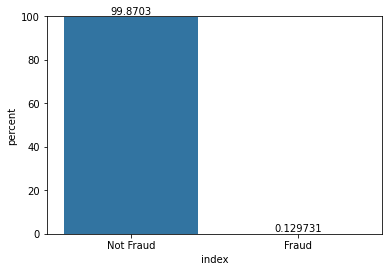

In [16]:
fraud_mapping = {1: 'Fraud', 0: 'Not Fraud'}

Y_train_map = Y_train['isFraud'].map(fraud_mapping)
Y_perc = Y_train_map.value_counts(normalize = True)
Y_perc = Y_perc.mul(100)
Y_perc = Y_perc.rename('percent').reset_index()


ax = sns.barplot(data = Y_perc, x="index", y="percent", errwidth=0)
ax.set(ylim=(0, 100))
for i in ax.containers:
    ax.bar_label(i,)

In [17]:
def splitNumCat(data):
    list_num = [var for var in data.columns if data[var].dtype != 'O']
    list_object = [var for var in data.columns if data[var].dtype == 'O']
    return list_num, list_object

list_num, list_object = splitNumCat(X_train)

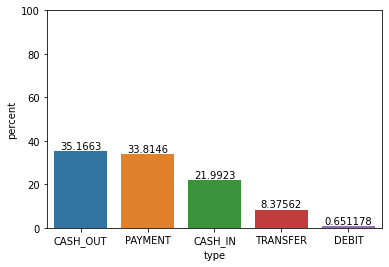

In [18]:
cat_perc = X[list_object].value_counts(normalize = True)
cat_perc = cat_perc.mul(100)
cat_perc = cat_perc.rename('percent').reset_index()


ax = sns.barplot(data = cat_perc, x="type", y="percent", errwidth=0)
ax.set(ylim=(0, 100))
for i in ax.containers:
    ax.bar_label(i,)

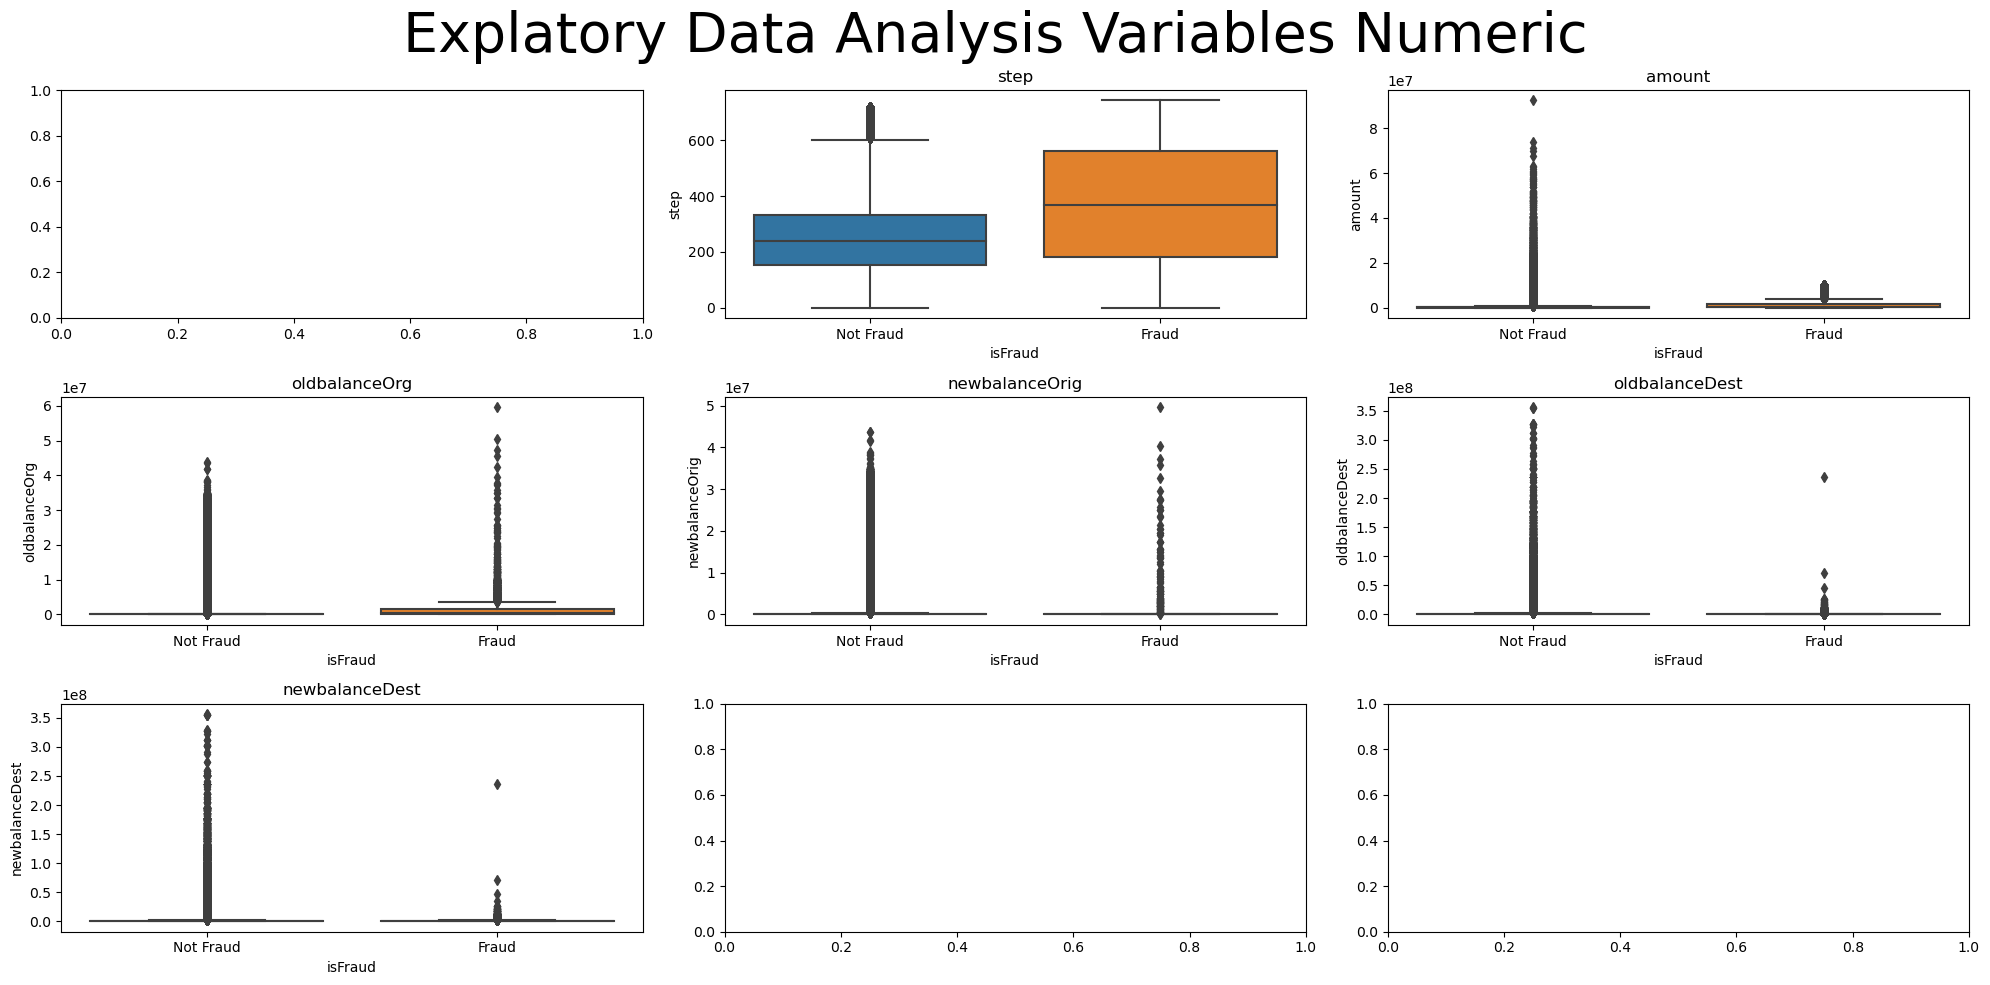

In [18]:
EDA_X_train_num = pd.concat([X_train[list_num],Y_train_map], axis=1)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

for i, (var, ax) in enumerate(zip(list_num, axes.flatten()[1:])):
    sns.boxplot(x='isFraud', y=var, data=EDA_X_train_num, orient='v', ax=ax)
    ax.set_title(var)
fig.suptitle('Explatory Data Analysis Variables Numeric', size =40)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

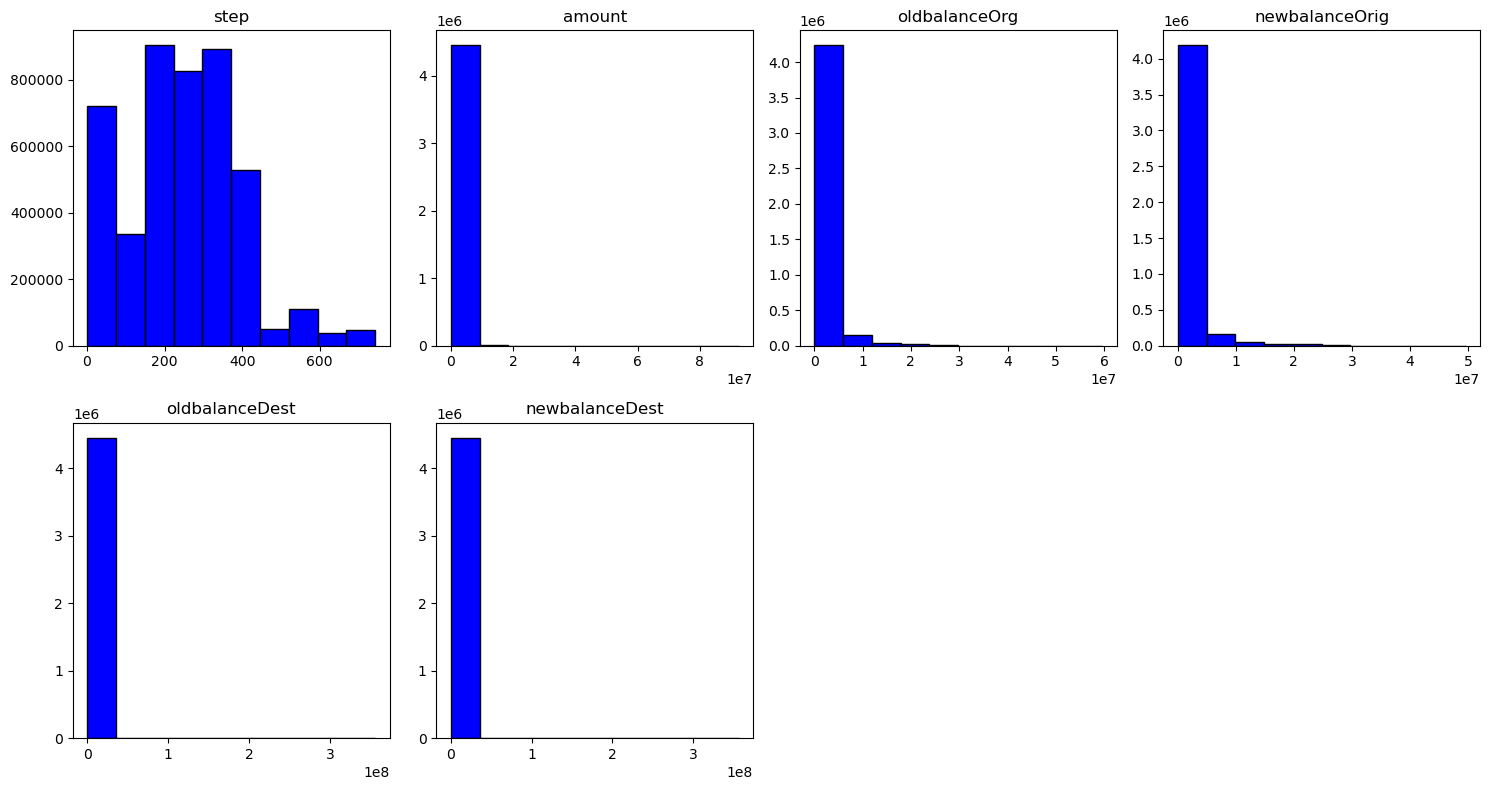

In [20]:
X_train[list_num].hist(bins = 10,
                                      figsize = (15, 8),
                                      layout = (-1, 4),
                                      grid = False,
                                      color = "blue",
                                      edgecolor = "black",
                                      )
plt.tight_layout()

In [21]:
for i in list_num:
  kurtosis = stats.mstats.kurtosis(X_train[i])
  skewness = stats.mstats.skew(X_train[i])
  print(f"{i} skewness: {np.round(skewness,2)}, kurtosis: {np.round(kurtosis,2)}")

step skewness: 0.38, kurtosis: 0.33
amount skewness: 31.37, kurtosis: 1868.95
oldbalanceOrg skewness: 5.24, kurtosis: 32.88
newbalanceOrig skewness: 5.17, kurtosis: 31.99
oldbalanceDest skewness: 20.1, kurtosis: 959.27
newbalanceDest skewness: 19.59, kurtosis: 879.42


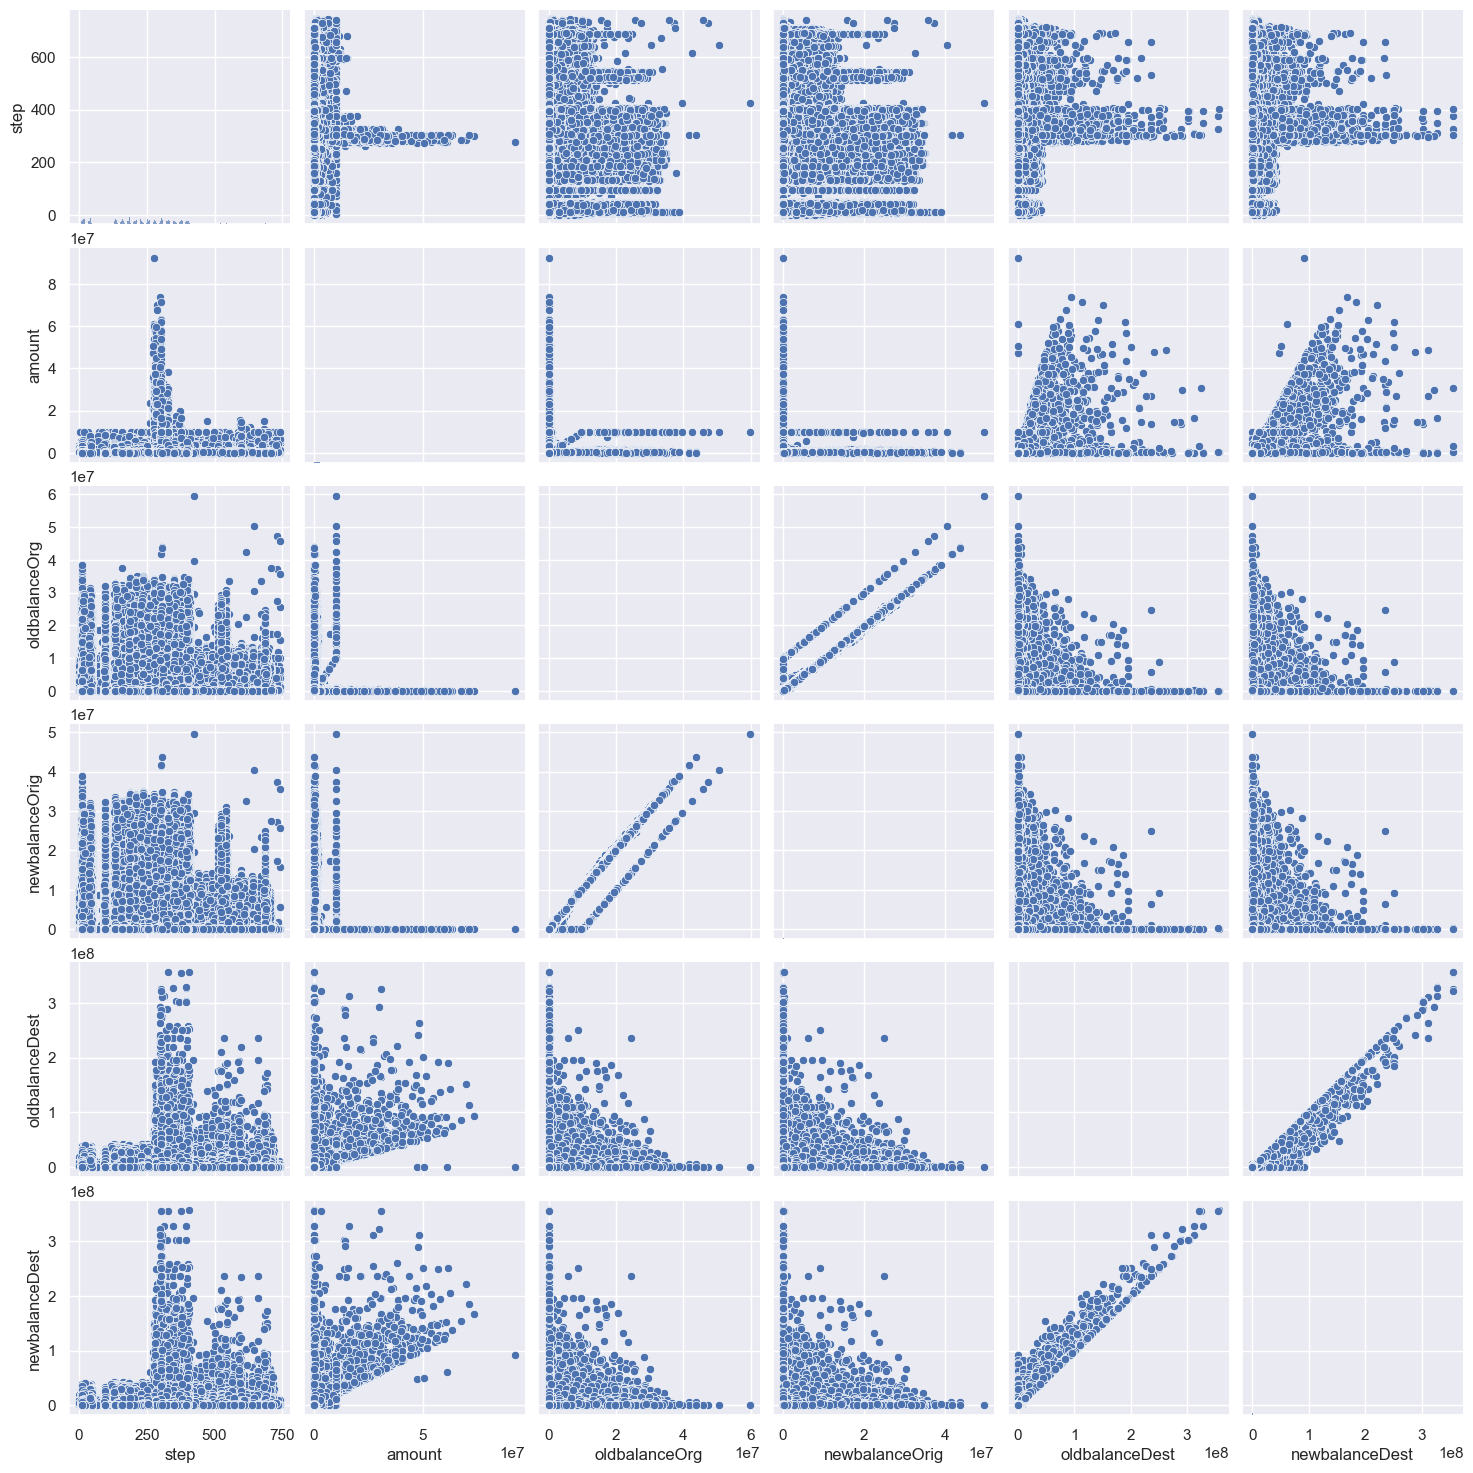

In [22]:
sns.set(rc={'figure.figsize':(14,8)})
sns.pairplot(X_train[list_num])

# Pre-Processing Data

### Data train

In [19]:
def OHE(data, col_cat, col_num, encoder_col = None, encoder = None):
  encode = OneHotEncoder()
  encode.fit(data[col_cat])
  ohe_col = encode.get_feature_names_out(col_cat)
  X_train_cat_ohe = encode.transform(data[col_cat]).toarray()
  X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe, columns=ohe_col, index=data[col_cat].index)

  data_numeric_ohe = pd.concat([data[col_num], X_train_cat_ohe], axis = 1)
  return data_numeric_ohe, ohe_col, encoder

X_train, ohe_col, encode_ohe = OHE(data = X_train, col_cat = list_object, col_num = list_num)
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2408104,202,26771.98,27521.00,54292.98,7175503.03,7148731.05,1.0,0.0,0.0,0.0,0.0
662430,36,344879.65,0.00,0.00,3731846.57,4076726.22,0.0,1.0,0.0,0.0,0.0
496595,20,1862607.84,0.00,0.00,3329828.01,4913631.27,0.0,0.0,0.0,0.0,1.0
5053741,354,37739.35,66684.93,28945.58,0.00,0.00,0.0,0.0,0.0,1.0,0.0
755621,38,376055.13,22501.00,0.00,182350.43,558405.55,0.0,1.0,0.0,0.0,0.0


<AxesSubplot:>

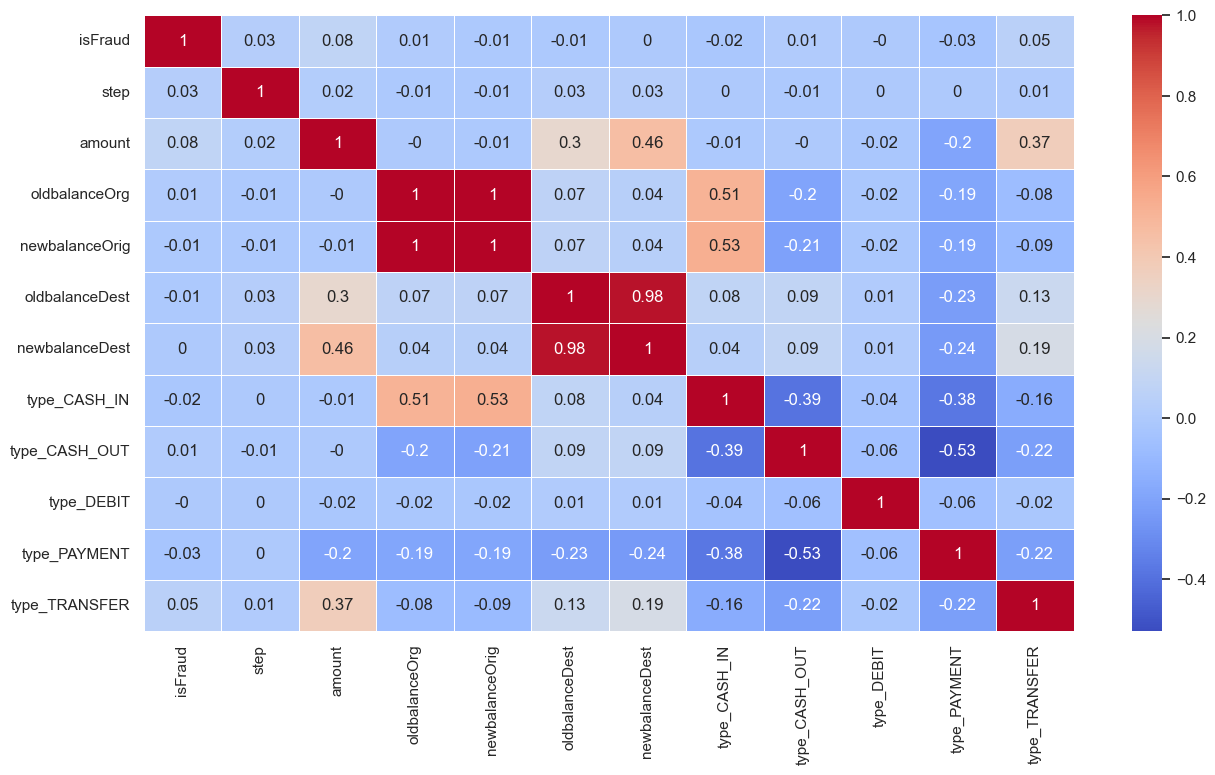

In [18]:
sns.set(rc={"figure.figsize":(15, 8)})
sns.heatmap(np.round(pd.concat([Y_train, X_train], axis=1).corr(),2), annot=True, cmap='coolwarm', linewidths=0.5)

In [28]:
params['data_train_path'][1]

'data/Processed/y_train.pkl'

### Data Validation

In [37]:
X_val, ohe_col, encode_ohe = OHE(data = X_val, col_cat = list_object, col_num = list_num)
X_val.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
912323,43,11345.37,22311.01,10965.64,0.00,0.00,0.0,0.0,0.0,1.0,0.0
5367131,375,474137.78,0.00,0.00,2108017.26,2582155.04,0.0,0.0,0.0,0.0,1.0
880378,42,258153.79,1034.00,0.00,861478.42,1334486.91,0.0,1.0,0.0,0.0,0.0
3417199,256,15117.14,16463.92,1346.78,0.00,0.00,0.0,0.0,0.0,1.0,0.0
1601102,156,54968.39,0.00,0.00,312176.53,367144.92,0.0,1.0,0.0,0.0,0.0


### Data Testing

In [38]:
X_test, ohe_col, encode_ohe = OHE(data = X_test, col_cat = list_object, col_num = list_num)
X_test.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
430688,18,102432.17,1159211.71,1261643.88,213836.31,111404.14,1.0,0.0,0.0,0.0,0.0
3399989,255,4016.33,0.00,0.00,0.00,0.00,0.0,0.0,0.0,1.0,0.0
5082235,355,135762.24,22327344.35,22463106.59,898944.63,763182.39,1.0,0.0,0.0,0.0,0.0
3898638,284,52271.67,8435406.86,8487678.54,291644.16,239372.48,1.0,0.0,0.0,0.0,0.0
2239475,186,7393.15,5589.00,0.00,0.00,0.00,0.0,0.0,0.0,1.0,0.0


In [41]:
save_to_pickle(X_train, params['data_train_path'][0])
save_to_pickle(Y_train, params['data_train_path'][1])
save_to_pickle(X_val, params['data_valid_path'][0])
save_to_pickle(Y_val, params['data_valid_path'][1])
save_to_pickle(X_test, params['data_test_path'][0])
save_to_pickle(Y_test, params['data_test_path'][1])

# Fitting Model

## Baseline/Benchmark

In [ ]:
Y_train.value_counts(normalize=True)*100

isFraud
0          99.870269
1           0.129731
dtype: float64

## Logistic Regression

In [42]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X= X_train,
            y= Y_train)
y_pred_dummy=dummy_clf.predict(X_train)
print(confusion_matrix(y_true=Y_train,
                y_pred=y_pred_dummy))
print("\n")
print(f"baseline accuracy {accuracy_score(y_true = Y_train, y_pred= y_pred_dummy)}")

[[4442306    5750]
 [   5769       9]]


baseline accuracy 0.9974136889699975


In [43]:
logreg = LogisticRegression()
logreg.fit(X=X_train, y=Y_train)

LogisticRegression()

In [47]:
y_pred_train_Logistic = logreg.predict(X_train)
confusion_matrix(y_true=Y_train,y_pred=y_pred_train_Logistic)
print(classification_report(y_true=Y_train, y_pred=y_pred_train_Logistic, target_names=["Not Fraud","Fraud"]))
print("precision score: ", precision_score(Y_train,y_pred_train_Logistic, average='macro'), "Recall Score: ", recall_score(Y_train, y_pred_train_Logistic, average='macro'), "F1 Score:", f1_score(Y_train, y_pred_train_Logistic, average='macro'))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   4448056
       Fraud       0.36      0.44      0.40      5778

    accuracy                           1.00   4453834
   macro avg       0.68      0.72      0.70   4453834
weighted avg       1.00      1.00      1.00   4453834

precision score:  0.6816817398169683 Recall Score:  0.7176601356432467 F1 Score: 0.6980421008446928


In [52]:
save_to_pickle(logreg, params['logistic_model'][0])

## Decission Tree

In [56]:
DT = DecisionTreeClassifier()
DT.fit(X=X_train, y=Y_train)
y_pred_train_DT = DT.predict(X_train)
print(confusion_matrix(y_true = Y_train, y_pred = y_pred_train_DT))
print(classification_report(y_true = Y_train, y_pred = y_pred_train_DT, target_names = ["Not Fraud","Fraud"]))
print("precision score: ", precision_score(Y_train,y_pred_train_DT, average='macro'), "Recall Score: ",
       recall_score(Y_train, y_pred_train_DT, average='macro'), "F1 Score:", 
       f1_score(Y_train, y_pred_train_DT, average='macro'))

[[4448056       0]
 [      0    5778]]
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   4448056
       Fraud       1.00      1.00      1.00      5778

    accuracy                           1.00   4453834
   macro avg       1.00      1.00      1.00   4453834
weighted avg       1.00      1.00      1.00   4453834

precision score:  1.0 Recall Score:  1.0 F1 Score: 1.0


In [58]:
save_to_pickle(DT, params['DT_model'][0])

# Random Forest

In [59]:
params['RF_model'][0]

'models/train/random_forest_model_default_train.pkl'

In [61]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X = X_train, y = Y_train)
y_pred_train_RF = rf_classifier.predict(X_train)
print(confusion_matrix(y_true= Y_train,y_pred=y_pred_train_RF))
print(classification_report(y_true = Y_train, y_pred = y_pred_train_RF, target_names = ["Not Fraud","Fraud"]))
print("precision score: ", precision_score(Y_train,y_pred_train_RF, average='macro'), "Recall Score: ",
       recall_score(Y_train, y_pred_train_RF, average='macro'), "F1 Score:", 
       f1_score(Y_train, y_pred_train_RF, average='macro'))

[[4448056       0]
 [      0    5778]]
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   4448056
       Fraud       1.00      1.00      1.00      5778

    accuracy                           1.00   4453834
   macro avg       1.00      1.00      1.00   4453834
weighted avg       1.00      1.00      1.00   4453834

precision score:  1.0 Recall Score:  1.0 F1 Score: 1.0


In [62]:
save_to_pickle(rf_classifier, params['RF_model'][0])

# Catboost

### Data Train

In [63]:
catboost_classifier = CatBoostClassifier()
catboost_classifier.fit(X_train, Y_train)
y_pred_train_catboost = catboost_classifier.predict(X_train)
print(confusion_matrix(y_true=Y_train, y_pred=y_pred_train_catboost))
print(classification_report(y_true = Y_train, y_pred = y_pred_train_catboost, target_names = ["Not Fraud","Fraud"]))

Learning rate set to 0.372343
0:	learn: 0.0621733	total: 864ms	remaining: 14m 22s
1:	learn: 0.0165981	total: 1.71s	remaining: 14m 14s
2:	learn: 0.0102415	total: 2.32s	remaining: 12m 52s
3:	learn: 0.0050278	total: 2.94s	remaining: 12m 13s
4:	learn: 0.0035167	total: 3.59s	remaining: 11m 53s
5:	learn: 0.0026662	total: 4.16s	remaining: 11m 28s
6:	learn: 0.0024240	total: 4.79s	remaining: 11m 19s
7:	learn: 0.0022946	total: 5.52s	remaining: 11m 25s
8:	learn: 0.0022304	total: 6.21s	remaining: 11m 23s
9:	learn: 0.0021243	total: 6.84s	remaining: 11m 17s
10:	learn: 0.0019940	total: 7.47s	remaining: 11m 11s
11:	learn: 0.0019374	total: 8.22s	remaining: 11m 16s
12:	learn: 0.0018850	total: 8.87s	remaining: 11m 13s
13:	learn: 0.0018112	total: 9.47s	remaining: 11m 7s
14:	learn: 0.0017625	total: 10.2s	remaining: 11m 8s
15:	learn: 0.0017337	total: 11s	remaining: 11m 14s
16:	learn: 0.0017194	total: 11.6s	remaining: 11m 11s
17:	learn: 0.0016799	total: 12.4s	remaining: 11m 14s
18:	learn: 0.0016130	total: 13

In [64]:
save_to_pickle(catboost_classifier, params['catboost_model'][0])

# XGBoost

### Data Train

In [65]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, Y_train)
y_pred_train_xgb = xgb_model.predict(X_train)
print(confusion_matrix(y_true=Y_train,y_pred=y_pred_train_xgb))
print(classification_report(y_true = Y_train, y_pred = y_pred_train_xgb, target_names = ["Not Fraud","Fraud"]))

[[4447968      88]
 [    568    5210]]
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   4448056
       Fraud       0.98      0.90      0.94      5778

    accuracy                           1.00   4453834
   macro avg       0.99      0.95      0.97   4453834
weighted avg       1.00      1.00      1.00   4453834



In [66]:
save_to_pickle(xgb_model, params['XGBoost_model'][0])

# Kesimpulan dari kesuluruhan model data training

In [67]:
print("############ LOGISTIC REGRESSION ############")
print(classification_report(y_true=Y_train, y_pred=y_pred_train_Logistic, target_names=["Not Fraud","Fraud"]))
print("\n")
print("############ Decission Tree ############")
print(classification_report(y_true=Y_train, y_pred=y_pred_train_DT, target_names=["Not Fraud","Fraud"]))
print("\n")
print("############ Random Forest ############")
print(classification_report(y_true=Y_train, y_pred=y_pred_train_RF, target_names=["Not Fraud","Fraud"]))
print("\n")
print("############ Catboost ############")
print(classification_report(y_true=Y_train, y_pred=y_pred_train_catboost, target_names=["Not Fraud","Fraud"]))
print("\n")
# print("############ Adaboost ############")
# print(classification_report(y_true=Y_train, y_pred=y_pred_train_adaboost, target_names=["Not Fraud","Fraud"]))
print("\n")
print("############ XGBoost ############")
print(classification_report(y_true=Y_train, y_pred=y_pred_train_xgb, target_names=["Not Fraud","Fraud"]))


############ LOGISTIC REGRESSION ############


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   4448056
       Fraud       0.36      0.44      0.40      5778

    accuracy                           1.00   4453834
   macro avg       0.68      0.72      0.70   4453834
weighted avg       1.00      1.00      1.00   4453834



############ Decission Tree ############
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   4448056
       Fraud       1.00      1.00      1.00      5778

    accuracy                           1.00   4453834
   macro avg       1.00      1.00      1.00   4453834
weighted avg       1.00      1.00      1.00   4453834



############ Random Forest ############
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   4448056
       Fraud       1.00      1.00      1.00      5778

    accuracy                           1.00   4453834
   macro avg       1.00      1.00      1.00

# Hyper Parameter Tuning

## Logistic Regression

In [68]:
param_dist = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': np.logspace(-4, 4, 100),  # Inverse of regularization strength (log scale)
    'solver': ['liblinear', 'saga'],  # Solver for optimization problem
    'max_iter': [100, 200, 300, 400]  # Maximum number of iterations
}

# Create a Logistic Regression model
logistic_regression = LogisticRegression()

# Create a RandomizedSearchCV object
random_search_logistic = RandomizedSearchCV(
    logistic_regression,  # Estimator (in this case, Logistic Regression)
    param_distributions=param_dist,  # Hyperparameter grid
    scoring='f1_weighted',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    verbose=1,  # Display progress
    n_jobs=-1  # Use all available CPU cores
)

# Fit the RandomizedSearchCV object to your data
random_search_logistic.fit(X_train, Y_train)


# Print the best hyperparameters found
print("Best Hyperparameters:", random_search_logistic.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'C': 0.0005336699231206312}


In [69]:
save_to_pickle(random_search_logistic.best_params_, params['logistic_model'][1])

## Decission Tree

In [70]:
param_grid_DT = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
}

random_search_DT = RandomizedSearchCV(
    estimator=DT,
    param_distributions=param_grid_DT,
    scoring='f1_weighted',
    cv=5,        # Number of cross-validation folds
    n_jobs=-1    # Use all available CPU cores
)
random_search_DT.fit(X_train, Y_train)
print("Best Hyperparameters Decission Tree:", random_search_DT.best_params_)

Best Hyperparameters Decission Tree: {'splitter': 'best', 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_depth': 5, 'criterion': 'entropy'}


In [71]:
save_to_pickle(random_search_DT.best_params_, params['DT_model'][1])

## Random Forest

In [72]:
param_grid_RF = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']}


random_search_RF = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_grid_RF,
    cv=5,        # Number of cross-validation folds
    n_jobs=-1    # Use all available CPU cores
)
random_search_RF.fit(X_train, Y_train)
print("Best Hyperparameter Random Forest:", random_search_RF.best_params_)

Best Hyperparameter Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}


In [73]:
save_to_pickle(random_search_RF.best_params_, params['RF_model'][1])

## catboost

In [74]:
param_grid_catboost = {
    'iterations': np.arange(100, 1000, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
}
random_search_catboost = RandomizedSearchCV(
    estimator=catboost_classifier,
    param_distributions=param_grid_catboost,
    # n_iter=100,  # Adjust the number of iterations as needed
    cv=5,        # Number of cross-validation folds
    n_jobs=-1,   # Use all available CPU cores
)

random_search_catboost.fit(X_train, Y_train)
print("Best Hyperparameter Catboost:", random_search_catboost.best_params_)

0:	learn: 0.0060852	total: 482ms	remaining: 1m 35s
1:	learn: 0.0050157	total: 1s	remaining: 1m 39s
2:	learn: 0.0026242	total: 1.66s	remaining: 1m 48s
3:	learn: 0.0022268	total: 2.22s	remaining: 1m 48s
4:	learn: 0.0021032	total: 2.72s	remaining: 1m 46s
5:	learn: 0.0018712	total: 3.21s	remaining: 1m 43s
6:	learn: 0.0018070	total: 3.72s	remaining: 1m 42s
7:	learn: 0.0017457	total: 4.21s	remaining: 1m 40s
8:	learn: 0.0016636	total: 4.71s	remaining: 1m 40s
9:	learn: 0.0015940	total: 5.19s	remaining: 1m 38s
10:	learn: 0.0015706	total: 5.71s	remaining: 1m 38s
11:	learn: 0.0014858	total: 6.2s	remaining: 1m 37s
12:	learn: 0.0014763	total: 6.7s	remaining: 1m 36s
13:	learn: 0.0014542	total: 7.17s	remaining: 1m 35s
14:	learn: 0.0014077	total: 7.67s	remaining: 1m 34s
15:	learn: 0.0013940	total: 8.22s	remaining: 1m 34s
16:	learn: 0.0013351	total: 8.73s	remaining: 1m 34s
17:	learn: 0.0013120	total: 9.27s	remaining: 1m 33s
18:	learn: 0.0012819	total: 9.77s	remaining: 1m 33s
19:	learn: 0.0012578	total:

In [77]:
save_to_pickle(random_search_catboost.best_params_, params['catboost_model'][1])

## XGBoost

In [78]:
%%time
param_grid_xgb = {
    'n_estimators': np.arange(200, 1000, 100),
    'learning_rate': [0.1, 0.5, 1.0],
    'max_depth': np.arange(2, 11),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    # n_iter=20,
    cv=5,
    n_jobs=-1,
)
random_search_xgb.fit(X_train, Y_train)

print("Best Hyperparameter XGBoost:", random_search_xgb)

Best Hyperparameter XGBoost: RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                              

In [79]:
print("Best Hyperparameter XGBoost:", random_search_xgb.best_params_)

Best Hyperparameter XGBoost: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [84]:
save_to_pickle(random_search_xgb.best_params_, params['XGBoost_model'][1])

# Evaluate Model

In [30]:
# Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 400, 'C': 1555.6761439304755}

## Logistic Regression

### Data Validation

In [90]:
logistic_regression_final = LogisticRegression(solver=random_search_logistic.best_params_['solver'], 
                                            penalty=random_search_logistic.best_params_['penalty'],
                                            max_iter=random_search_logistic.best_params_['max_iter'],
                                            C= random_search_logistic.best_params_['C'])
logistic_regression_final.fit(X = X_train, y = Y_train)
y_pred_val_logistic = logistic_regression_final.predict(X_val)
print(confusion_matrix(y_true= Y_val,y_pred=y_pred_val_logistic))
print(classification_report(y_true = Y_val, y_pred = y_pred_val_logistic, target_names = ["Not Fraud","Fraud"]))

[[953104     62]
 [   670    557]]
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    953166
       Fraud       0.90      0.45      0.60      1227

    accuracy                           1.00    954393
   macro avg       0.95      0.73      0.80    954393
weighted avg       1.00      1.00      1.00    954393



In [92]:
save_to_pickle(logistic_regression_final,params['logistic_model'][2])

## Decission Tree

### Data Validation

 Best Hyperparameters Decission Tree: {'splitter': 'best', 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy'}

In [99]:
DT_final = DecisionTreeClassifier(splitter = random_search_DT.best_params_['splitter'], 
                            min_samples_split=random_search_DT.best_params_['min_samples_split'],
                            min_samples_leaf=random_search_DT.best_params_['min_samples_leaf'],
                            max_depth=random_search_DT.best_params_['max_depth'],
                            criterion=random_search_DT.best_params_['criterion'])
DT_final.fit(X=X_train, y=Y_train)
y_pred_val_DT = DT_final.predict(X_val)
print(confusion_matrix(y_true = Y_val, y_pred = y_pred_val_DT))
print(classification_report(y_true = Y_val, y_pred = y_pred_val_DT, target_names = ["Not Fraud","Fraud"]))

[[953075     91]
 [   383    844]]
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    953166
       Fraud       0.90      0.69      0.78      1227

    accuracy                           1.00    954393
   macro avg       0.95      0.84      0.89    954393
weighted avg       1.00      1.00      1.00    954393



In [100]:
save_to_pickle(DT_final, params['DT_model'][2])

## Random Forest

### Data Validation

Best Hyperparameter Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}

In [107]:
random_search_RF.best_params_['max_depth']

20

In [108]:
RF_final = RandomForestClassifier(n_estimators = random_search_RF.best_params_['n_estimators'], 
                            min_samples_split=random_search_RF.best_params_['min_samples_split'], 
                            min_samples_leaf=random_search_RF.best_params_['min_samples_leaf'], 
                            max_features=random_search_RF.best_params_['max_features'],
                            max_depth=random_search_RF.best_params_['max_depth'], 
                            criterion = random_search_RF.best_params_['criterion'])
RF_final.fit(X=X_train, y=Y_train)
y_pred_val_RF = RF_final.predict(X_val)
print(confusion_matrix(y_true = Y_val, y_pred = y_pred_val_RF))
print(classification_report(y_true = Y_val, y_pred = y_pred_val_RF, target_names = ["Not Fraud","Fraud"]))
save_to_pickle(RF_final, params['RF_model'][2])

[[953147     19]
 [   283    944]]
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    953166
       Fraud       0.98      0.77      0.86      1227

    accuracy                           1.00    954393
   macro avg       0.99      0.88      0.93    954393
weighted avg       1.00      1.00      1.00    954393



## Catboost

### Data Validation

Best Hyperparameter Catboost: {'learning_rate': 1.0, 'l2_leaf_reg': 7, 'iterations': 200, 'depth': 4, 'border_count': 64}

In [109]:
catboost_classifier_final = CatBoostClassifier(learning_rate=0.1, 
                                         l2_leaf_reg=3, 
                                         iterations = 900, 
                                         depth=10, 
                                         border_count=128)
catboost_classifier_final.fit(X_train, Y_train)
y_pred_val_catboost = catboost_classifier_final.predict(X_val)
print(confusion_matrix(y_true=Y_val, y_pred=y_pred_val_catboost))
print(classification_report(y_true = Y_val, y_pred = y_pred_val_catboost, target_names = ["Not Fraud","Fraud"]))
save_to_pickle(catboost_classifier_final, params['catboost_model'][2])

0:	learn: 0.3645657	total: 1.08s	remaining: 16m 10s
1:	learn: 0.1861868	total: 2.32s	remaining: 17m 20s
2:	learn: 0.0885439	total: 3.55s	remaining: 17m 41s
3:	learn: 0.0448368	total: 4.73s	remaining: 17m 39s
4:	learn: 0.0240177	total: 6.14s	remaining: 18m 19s
5:	learn: 0.0143058	total: 7.45s	remaining: 18m 29s
6:	learn: 0.0088031	total: 8.84s	remaining: 18m 47s
7:	learn: 0.0060091	total: 10.2s	remaining: 18m 59s
8:	learn: 0.0045866	total: 12.2s	remaining: 20m 10s
9:	learn: 0.0036566	total: 14.7s	remaining: 21m 52s
10:	learn: 0.0031339	total: 17.2s	remaining: 23m 7s
11:	learn: 0.0027602	total: 19.4s	remaining: 23m 52s
12:	learn: 0.0025091	total: 21s	remaining: 23m 52s
13:	learn: 0.0023088	total: 22.9s	remaining: 24m 6s
14:	learn: 0.0021755	total: 24.1s	remaining: 23m 43s
15:	learn: 0.0020276	total: 25.7s	remaining: 23m 41s
16:	learn: 0.0019675	total: 27.3s	remaining: 23m 38s
17:	learn: 0.0018914	total: 29.2s	remaining: 23m 49s
18:	learn: 0.0017958	total: 30.8s	remaining: 23m 48s
19:	lea

## XGBoost

### Data Validation

Best Hyperparameter XGBoost: {'subsample': 0.9, 'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

In [110]:
xgb_model_final = xgb.XGBClassifier(subsample=random_search_xgb.best_params_['subsample'], 
                              n_estimators= random_search_xgb.best_params_['n_estimators'], 
                              max_depth = random_search_xgb.best_params_['max_depth'], 
                              learning_rate = random_search_xgb.best_params_['learning_rate'], 
                              colsample_bytree =random_search_xgb.best_params_['colsample_bytree'])
xgb_model_final.fit(X_train, Y_train)
y_pred_val_xgb = xgb_model_final.predict(X_val)
print(confusion_matrix(y_true=Y_val,y_pred=y_pred_val_xgb))
print(classification_report(y_true = Y_val, y_pred = y_pred_val_xgb, target_names = ["Not Fraud","Fraud"]))
save_to_pickle(xgb_model_final, params['XGBoost_model'][2])

[[953105     61]
 [   186   1041]]
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    953166
       Fraud       0.94      0.85      0.89      1227

    accuracy                           1.00    954393
   macro avg       0.97      0.92      0.95    954393
weighted avg       1.00      1.00      1.00    954393



# Implementasi Data Test

In [111]:
y_pred_test_xgb = xgb_model.predict(X_test)
print(confusion_matrix(y_true=Y_test,y_pred=y_pred_test_xgb))
print(classification_report(y_true = Y_test, y_pred = y_pred_test_xgb, target_names = ["Not Fraud","Fraud"]))

[[953134     51]
 [   162   1046]]
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    953185
       Fraud       0.95      0.87      0.91      1208

    accuracy                           1.00    954393
   macro avg       0.98      0.93      0.95    954393
weighted avg       1.00      1.00      1.00    954393



# SHAP Value

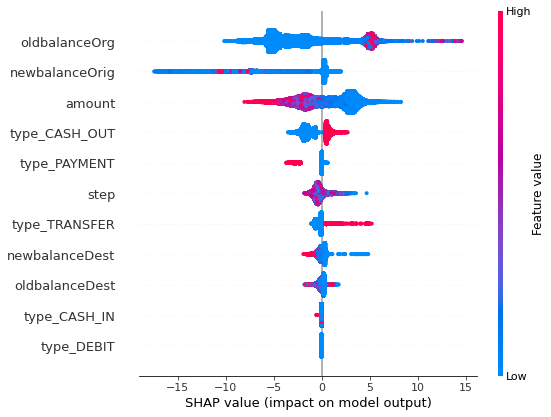

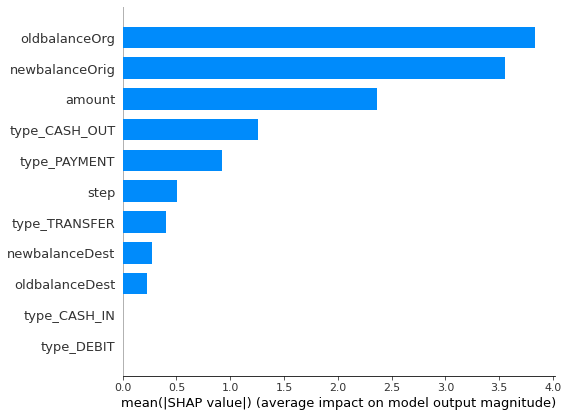

In [112]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test[:95439])
shap.summary_plot(shap_values, X_test[:95439])
shap.summary_plot(shap_values, X_test[:95439], plot_type="bar")

### Old Balance
Nilai Old Balance yang rendah maka cenderung mendorong hasil prediksi ke tidak fraud, dan sebaliknya

### Amount
Nilai Transaksi yang tinggi maka cenderung mendorong hasil prediksi ke tidak fraud dan sebaliknya

### Type Cash OUt
Jika User melakukan trasaksi Kredit maka si user cenderung mendorong hasil prediski fraud

### Type Transfer
Jika user melakukan transfer kredit maka si user cenderung mendorong hasil prediksi Fraud dan sebaliknya